#### Import libraries  

In [47]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import odeint, solve_ivp
from scipy.optimize import minimize

#### Parameters  

In [48]:
csv_in = 'cov_japan_2021_07_30.csv'

dt = 0.01  # for odeint

#### Definition of differencial equations of SEIR model  
- S: #Susceptible = the number of people who are not immune
 - 影響を受けやすい = 免疫を持たない人数  
- E: #Exposed = the number of people who are infected and during the incubation period
 - 曝露されている = 感染し、かつ潜伏期間中の人数
- I: #Infectious = the number of people who are onset
 - 伝染性のある = すでに発症している人数
- R: #Removed = the number of people who have been infected and are recovered (have immunity) or dead
 - この系から取り除かれた = 免疫を獲得した or 死亡した人数
- beta: infectious rate (S -> E, 感染率)
- lp: length of latent period (incubation period, E -> I, 潜伏期間)
- ip: length of infectious period (I -> R, 感染期間)

In [49]:
def seir_eq(v, t, beta, lp, ip):
    S, E, I, R = v
    dSdt = -beta * S * I
    dEdt = beta * S * I - E / lp
    dIdt = E / lp - I / ip
    dRdt = I / ip
    return dSdt, dEdt, dIdt, dRdt

#### Function to estimate S,E,I,R from SEIR model with given parameters   

In [50]:
def estimate_seir(seir_eq, init_state, t, beta, lp, ip, num_t, step_t):
    sol = odeint(seir_eq, init_state, t, args=(beta, lp, ip))
    est = sol[0:num_t:step_t]
    return est

#### Read CSV file  

In [60]:
df = pd.read_csv(csv_in, sep=',', skiprows=0, header=0)
print(df.shape)
print(df.info())

(550, 8)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 550 entries, 0 to 549
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Infected_total   550 non-null    int64 
 1   Deaths_total     550 non-null    int64 
 2   Recovered_total  550 non-null    int64 
 3   Confirmed        550 non-null    int64 
 4   Deaths           550 non-null    int64 
 5   Recovered        550 non-null    int64 
 6   Removed_tol      550 non-null    int64 
 7   Date             550 non-null    object
dtypes: int64(7), object(1)
memory usage: 34.5+ KB
None


In [61]:
df.drop(['Deaths_total','Recovered_total'],axis=1,inplace=True)

In [62]:
display(df.head())
display(df.tail())

,Infected_total,Confirmed,Deaths,Recovered,Removed_tol,Date
0,2,0,0,0,0,2020-01-22
1,2,0,0,0,0,2020-01-23
2,2,0,0,0,0,2020-01-24
3,2,2,0,1,0,2020-01-25
4,4,0,0,0,1,2020-01-26


,Infected_total,Confirmed,Deaths,Recovered,Removed_tol,Date
545,876059,7708,12,3263,831803,2021-07-20
546,883767,9675,78,3763,835078,2021-07-21
547,893442,10684,14,3471,838919,2021-07-22
548,904126,10592,9,3715,842404,2021-07-23
549,914718,12340,9,3880,846128,2021-07-24


In [64]:
df['Date'] = pd.to_datetime(df['Date'])
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 550 entries, 0 to 549
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Infected_total  550 non-null    int64         
 1   Confirmed       550 non-null    int64         
 2   Deaths          550 non-null    int64         
 3   Recovered       550 non-null    int64         
 4   Removed_tol     550 non-null    int64         
 5   Date            550 non-null    datetime64[ns]
dtypes: datetime64[ns](1), int64(5)
memory usage: 25.9 KB
None


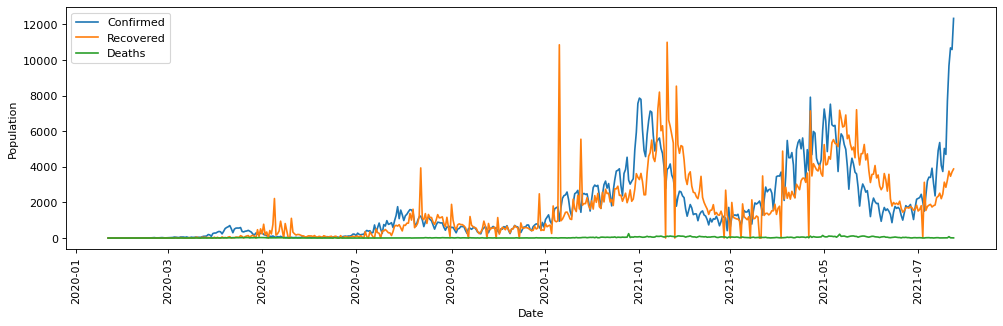

In [67]:
from matplotlib.pyplot import figure
figure(figsize=(15, 4), dpi=80)

plt.plot(df['Date'], df['Confirmed'], label='Confirmed')
plt.plot(df['Date'], df['Recovered'], label='Recovered')
plt.plot(df['Date'], df['Deaths'], label='Deaths')
plt.xticks(rotation=90)
plt.xlabel('Date')
plt.ylabel('Population')
plt.legend()
plt.show()

In [70]:
obs_i = df['Infected_total']
obs_r = df['Removed_tol']
print((obs_i+obs_r).max())

1760846


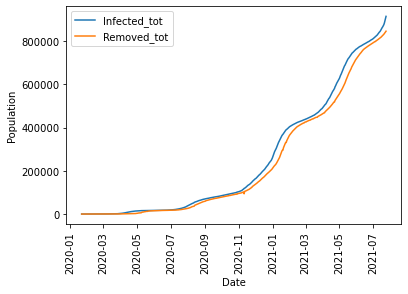

In [71]:
plt.plot(df['Date'], obs_i, label='Infected_tot')
plt.plot(df['Date'], obs_r, label='Removed_tot')
plt.xticks(rotation=90)
plt.xlabel('Date')
plt.ylabel('Population')
plt.legend()
plt.show()

### Define t

In [72]:
t_max = len(obs_i)
t = np.arange(0, t_max, dt)
num_t = int(t_max/dt)
step_t = int(1/dt)

In [73]:
#Objective function: mean square deviation of I and R

def y(params, seir_eq, init_state, t, num_t, step_t):
    beta, lp, ip = params
    est = estimate_seir(seir_eq, init_state, t, beta, lp, ip, num_t, step_t)
    est_i = est[:, 2]
    est_r = est[:, 3]
    diff_i = est_i - obs_i
    diff_r = est_r - obs_r
    return np.sum(diff_i*diff_i + diff_r*diff_r)

In [74]:
# Optimize the objective function

init_S = 20000
init_E = 100
init_I = 15
init_R = 1
init_state = [init_S, init_E, init_I, init_R]
n_population = np.sum(init_state)

init_beta = 0.3 / n_population
init_lp = 2.0
init_ip = 7.0

init_params = [init_beta, init_lp, init_ip]
results = minimize(y, init_params, args=(seir_eq, init_state, t, num_t, step_t),
                   method='nelder-mead')

print(results)

C:\Users\maidu\.conda\envs\tf\lib\site-packages\scipy\integrate\odepack.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
<ipython-input-49-d92e5eaff1e5>:4: RuntimeWarning: overflow encountered in double_scalars
  dEdt = beta * S * I - E / lp
<ipython-input-49-d92e5eaff1e5>:5: RuntimeWarning: overflow encountered in double_scalars
  dIdt = E / lp - I / ip


 final_simplex: (array([[2.06481861e+05, 4.60295348e+01, 9.66066659e+10],
       [2.06481861e+05, 4.60295348e+01, 9.66066659e+10],
       [2.06481861e+05, 4.60295348e+01, 9.66066659e+10],
       [2.06481861e+05, 4.60295348e+01, 9.66066659e+10]]), array([1.41949218e+14, 1.41949218e+14, 1.41949218e+14, 1.41949218e+14]))
           fun: 141949218339541.62
       message: 'Maximum number of function evaluations has been exceeded.'
          nfev: 602
           nit: 288
        status: 1
       success: False
             x: array([2.06481861e+05, 4.60295348e+01, 9.66066659e+10])


In [75]:
beta_opt = results.x[0]
lp_opt = results.x[1]
ip_opt = results.x[2]

print('Optimized parameters:')
print('  beta:', beta_opt)
print('  lp:', lp_opt)
print('  ip:', ip_opt)
R0 = beta_opt * n_population * ip_opt
print('R0:', R0)

Optimized parameters:
  beta: 206481.86067217364
  lp: 46.02953475002859
  ip: 96606665946.2633
R0: 4.0126439555838994e+20


In [77]:
#Result of the fitting to #Infected
t_max = len(obs_i)
t = np.arange(0, t_max, dt)
num_t = int(t_max/dt)
step_t = int(1/dt)
print('t_max:', t_max)
est = estimate_seir(seir_eq, init_state, t, beta_opt, lp_opt, ip_opt, num_t, step_t)

t_max: 550


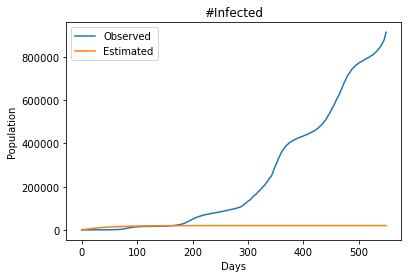

In [78]:
est_i = est[:, 2]
plt.plot(obs_i, label='Observed')
plt.plot(est_i, label='Estimated')
plt.title('#Infected')
plt.xlabel('Days')
plt.ylabel('Population')
plt.legend()
plt.show()